# Code to generate the main figure from the paper
### Based on code supplied by Jenner et al. in the "Evidence of Learned Look-Ahead in a Chess-Playing Neural Network" paper.

## Load the puzzles, select a puzzle and evaluate it

In [1]:
from leela_interp import Lc0sight, LeelaBoard
from leela_logit_lens import LeelaLogitLens
import pickle
import torch
import chess
import pandas as pd

In [2]:
# load the puzzles
with open("../data/interesting_puzzles_history.pkl", "rb") as f:
    puzzles = pickle.load(f)

In [3]:
puzzles.columns

Index(['PuzzleId', 'FEN', 'Moves', 'Rating', 'RatingDeviation', 'Popularity',
       'NbPlays', 'Themes', 'GameUrl', 'OpeningTags', 'principal_variation',
       'full_pv_probs', 'full_model_moves', 'full_wdl',
       'sparring_full_pv_probs', 'sparring_full_model_moves', 'sparring_wdl',
       'different_targets', 'corrupted_fen', 'Original_PGN', 'Puzzle_PGN'],
      dtype='object')

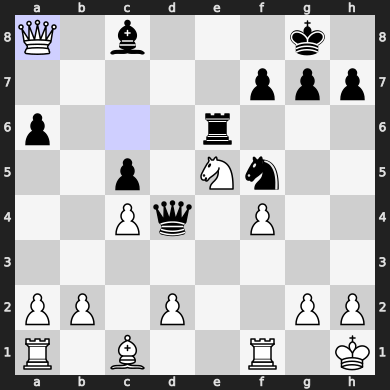

In [4]:
# This is the puzzle from the paper you can also try out different ones
puzzle_index = 8393
puzzle = puzzles.iloc[puzzle_index]
board = LeelaBoard.from_pgn(puzzle['Puzzle_PGN'])
# board = LeelaBoard.from_pgn(puzzle['PGN'])
board

In [29]:
board.fen()

'Q1b3k1/5ppp/p3r3/2p1Nn2/2Pq1P2/8/PP1P2PP/R1B2R1K b - - 0 17'

In [5]:
puzzle.principal_variation

['f5g3', 'h2g3', 'e6h6']

In [6]:
model = Lc0sight("../lc0-original.onnx")
lens = LeelaLogitLens(model=model)

Using device: cpu


In [7]:
results = lens.multi_layer_lens(board, output="policy", return_probs=True, return_policy_as_dict=True)

### Code for plotting the evaluations 

In [8]:
import pickle

import chess
import chess.svg
import iceberg as ice
import numpy as np
import torch
from leela_interp import Lc0sight, LeelaBoard
from leela_interp.tools import figure_helpers as fh
from leela_logit_lens.tools.utils import get_top_k_moves
from leela_logit_lens.tools.plotting_helpers import make_translucent_arrows, PolicyBarWithColors

In [9]:
move_colors = [
   ice.Color.from_hex(fh.COLORS[2]),  # red
   ice.Color.from_hex(fh.COLORS[0]),  # green
   ice.Color.from_hex(fh.COLORS[1]),  # blue
]

In [10]:
def add_frame(obj, fill_color=ice.WHITE, border_radius=0.0):
    rect = ice.Rectangle(
        obj.pad(5).bounds,
        fill_color=fill_color,
        border_radius=border_radius,
    )
    return rect.add_centered(obj)

In [11]:
class Neuron(ice.DrawableWithChild):
    content: ice.Drawable
    corrupted: bool = False
    border_radius: float = 0.0
    border_color: ice.Color = ice.BLACK
    border_thickness: float = 3
    alpha: float = 1.0

    def setup(self):
        fill_color = ice.Color.from_hex("#d63031") if self.corrupted else ice.WHITE
        self.rect = fh.HatchedRectangle(
            self.content.pad(5).bounds,
            border_color=self.border_color,
            border_thickness=self.border_thickness,
            fill_color=fill_color,
            border_radius=self.border_radius,
            hatched=self.corrupted,
            hatched_thickness=4,
            hatched_angle=-45,
            hatched_spacing=15,
        )
        self.set_child(self.rect.add_centered(self.content))

In [12]:
# True is dark squares
SQUARE_COLORS = {
    True: ice.Color.from_hex("#cfcfcf"),
    False: ice.Color.from_hex("#f5f5f5"),
}


class LeelaForwardPass(ice.DrawableWithChild):
    board: LeelaBoard
    policy: dict[str, float]
    include_squares: list[str]
    input_arrow_squares: list[str]
    changed_policy: list[float] | None = None
    board_heatmap: dict[str, str] | None = None
    move_arrow: str | None = None
    board_title: str | None = None

    def setup(self):
        heatmap = self.board_heatmap or {}
        board = self.board
        ice_pieces = {}
        for piece_name, svg_text in chess.svg.PIECES.items():
            ice_pieces[piece_name] = ice.SVG(
                raw_svg=chess.svg.piece(chess.Piece.from_symbol(piece_name))
            )

        empty_piece = ice.SVG(
            raw_svg=chess.svg.piece(chess.Piece.from_symbol(piece_name))
        ).opacity(0)

        piece_array = []
        colors = []
        self.sq2idx = {}
        # reversed so that black is on top
        for square in reversed(chess.SQUARES):
            square_name = chess.SQUARE_NAMES[square]
            rank = chess.square_rank(square)
            file = chess.square_file(square)
            is_dark = (rank + file) % 2 == 0

            color = SQUARE_COLORS[is_dark]
            if square_name in heatmap:
                color = ice.Color.from_hex(heatmap[square_name])

            if square_name in self.include_squares:
                piece = board.pc_board.piece_at(square)
                self.sq2idx[square_name] = len(piece_array)

                if piece is None:
                    piece_array.append("")
                    colors.append(color)
                else:
                    piece_array.append(piece.symbol())
                    colors.append(color)
            else:
                if len(piece_array) and piece_array[-1] != "...":
                    piece_array.append("...")
                    colors.append(color)

        dots = ice.MathTex("\\vdots").scale(5)

        piece_objects = []

        for piece_name, color in zip(piece_array, colors):
            if piece_name == "":
                piece_objects.append(add_frame(empty_piece, fill_color=color))
            elif piece_name == "...":
                piece_objects.append(dots)
            else:
                piece_objects.append(
                    add_frame(ice_pieces[piece_name], fill_color=color)
                )

        tokenized_content = (
            ice.Arrange(piece_objects, gap=20, arrange_direction=ice.VERTICAL)
            .pad(5)
            .background(ice.WHITE)
        )

        # Calculate the actual network height
        network_height = tokenized_content.bounds.height
        
        # Add rectangle around the input layer (tokenized pieces)
        input_rect = ice.Rectangle(
            tokenized_content.bounds.inset(-10),
            border_color=ice.Color.from_hex("#3498db"),
            border_thickness=8,
            fill_color=ice.TRANSPARENT,
            border_radius=20
        )
        tokenized_pieces = input_rect.add_centered(tokenized_content)

        self.input_rect = input_rect

        board_arrows = {}
        if self.move_arrow:
            board_arrows[self.move_arrow] = fh.BEST_MOVE_COLOR + "80"
        ice_board = board.plot(
            heatmap=heatmap, show_lastmove=False, arrows=board_arrows
        )


        # Get the original height of the board (it's 390 based on the iceberg code)
        original_board_height = ice_board.bounds.height
        # Calculate the scale needed to match the network height
        scale_factor = network_height / original_board_height


        # Start with just the scaled chess board (no title yet)
        transformed_board = ice_board.scale(scale_factor)
        transformed_board = transformed_board.crop(transformed_board.bounds)
        if self.board_title:
            title = ice.Text(
                self.board_title,
                ice.FontStyle("Monaco", size=100),
            ).pad(10)
            # Add title relative to the actual chess board (transformed_board), not the padded version
            transformed_board += title.relative_to(
                transformed_board, ice.BOTTOM_MIDDLE, ice.TOP_MIDDLE
            )
        
        padded_ice_board = transformed_board.pad_right(20).pad_bottom(150)


        # Add curly brace 
        input_brace = ice.Brace(target_width=network_height, target_height=40)
        input_brace = ice.Transform(child=input_brace, rotation=90).pad_right(20)  # Point toward board
        
        # Position between network and board
        padded_ice_board += input_brace.relative_to(padded_ice_board, ice.MIDDLE_LEFT, ice.MIDDLE_RIGHT)

        
        # Create the scene with just the board (no title)
        scene = padded_ice_board
        
        # Position tokenized pieces relative to the board center (without title influence)
        scene += tokenized_pieces.relative_to(
            padded_ice_board, ice.MIDDLE_LEFT, ice.MIDDLE_RIGHT
        )

        with scene:
            i = 0
            for piece in reversed(piece_objects):
                if piece == dots:
                    continue

                square = self.include_squares[i]
                if square not in self.input_arrow_squares:
                    i += 1
                    continue

                square_rect = ice_board.square(chess.parse_square(square))
                sx, sy = square_rect.relative_bounds.corners[ice.CENTER]
                ex, ey = piece.relative_bounds.corners[ice.MIDDLE_LEFT]
                midpoint = (np.array([sx, sy]) + np.array([ex, ey])) / 2
                normal = np.array([ey - sy, sx - ex])
                # normal /= np.linalg.norm(normal)
                rank = chess.square_rank(chess.parse_square(square))
                if rank < 4:
                    normal *= -1
                path = ice.CurvedCubicLine(
                    points=[
                        (sx, sy),
                        midpoint + normal * 0.2,
                        (ex, ey),
                    ],
                    path_style=ice.PathStyle(
                        color=ice.BLACK.with_alpha(0.7), thickness=3
                    ),
                )
                arrow = ice.ArrowPath(
                    path, arrow_head_style=ice.ArrowHeadStyle.FILLED_TRIANGLE
                )
                scene += arrow
                i += 1

        if len(self.input_arrow_squares) == 0:
            with scene:
                sx, sy = transformed_board.relative_bounds.corners[ice.MIDDLE_RIGHT]
                sy -= 100
                sx += 30

                ex, ey = tokenized_pieces.relative_bounds.corners[ice.MIDDLE_LEFT]
                ex -= 30

                path = ice.CubicBezier(
                    [
                        (sx, sy),
                        (sx + 200, sy),
                        (ex - 200, ey),
                        (ex, ey),
                    ],
                    ice.PathStyle(color=ice.BLACK, thickness=4),
                )
                arrow = ice.ArrowPath(
                    path, arrow_head_style=ice.ArrowHeadStyle.FILLED_TRIANGLE
                )
                scene += arrow

        def get_neurons():
            neurons = []
            for piece_name in piece_array:
                if piece_name == "...":
                    neurons.append(dots)
                else:
                    neurons.append(Neuron(content=empty_piece, border_radius=20))
            return neurons

        # Define which layers to show
        layers_to_show = [1, 3, 5, 7, 9, 11, 13]# , 15]  

        layers = []
        layer_rectangles = [self.input_rect]
        last_layer = tokenized_pieces

        for i, layer in enumerate(layers_to_show):
            new_neurons = get_neurons()
            layers.append(new_neurons)
            
            layer_content = (
                ice.Arrange(new_neurons, gap=20, arrange_direction=ice.VERTICAL)
                .pad(5)
                .background(ice.WHITE)
            )
            
            # Add rectangle around every second layer 
            if i % 2 != 0 and i != len(layers_to_show) - 1: 
                layer_rect = ice.Rectangle(
                    layer_content.bounds.inset(-10),
                    border_color=ice.Color.from_hex("#3498db"),
                    border_thickness=8,
                    fill_color=ice.TRANSPARENT,
                    border_radius=20
                )
                layer = layer_rect.add_centered(layer_content).pad_left(200)
                # Store the rectangle for later access
                layer_rectangles.append(layer_rect)
            else:
                layer = layer_content.pad_left(200)
                # Store None for layers without rectangles
                layer_rectangles.append(None)

            with scene:
                scene += layer.relative_to(last_layer, ice.TOP_LEFT, ice.TOP_RIGHT)

            last_layer = layer

        # Plot the Model Output
        with scene: 
            # Get policy for full model
            output_policy = results[0]['layers'][15]['policy_as_dict']

            print(output_policy)

            # Create translucent arrows for top moves
            arrows_for_output = make_translucent_arrows(
                policy_as_dict=output_policy,
                k=3,  
                colors=move_colors
            )

            copy_board = board.copy()

            # Plot a board using the policy arrows
            output_board = copy_board.plot(
                arrows=arrows_for_output,
                show_lastmove=False,
            )       

            output_board = output_board.scale(scale_factor)
            output_board = output_board.crop(output_board.bounds)
            output_title = ice.Text(
                "Model Output",
                ice.FontStyle("Monaco", size=100),
            ).pad(10)
            
            # First arrange board and title vertically
            output_board_with_title = output_board + output_title.relative_to(
                output_board, ice.BOTTOM_MIDDLE, ice.TOP_MIDDLE
            )
            
            # Create policy bar for the output
            top_moves_for_output = get_top_k_moves(output_policy, k=3)
            output_policy_dict_uci = dict(top_moves_for_output)

            # Use the board object to convert UCI keys to SAN keys for plotting
            output_policy_dict_san = {
                board.pc_board.san(chess.Move.from_uci(move)): prob
                for move, prob in output_policy_dict_uci.items()
            }

            print(output_policy_dict_san)

            
            output_policy_bar = PolicyBarWithColors(
                numbers=list(output_policy_dict_san.values()),
                bar_labels=list(output_policy_dict_san.keys()),
                bar_colors=move_colors,
                label_font_family=fh.FONT_FAMILY,
                bar_height=60,  # Same as the other policy bars
                use_tex=True,
                move_scale=0.6,  # Same scale as other bars
                bar_width=25,    # Same width as other bars
                label_font_size=18,
            ).scale(5)  # Same scale as other bars
            
            # Arrange board+title and policy bar horizontally
            output_board_complete = ice.Arrange(
                [output_board_with_title, output_policy_bar.pad_top(340)], 
                gap=80, 
                arrange_direction=ice.HORIZONTAL
            )
            
            padded_output_board = output_board_complete.pad_left(20).pad_bottom(150)

            # Add curly brace 
            output_brace = ice.Brace(target_width=network_height, target_height=50)
            output_brace = ice.Transform(child=output_brace, rotation=-90).pad_left(20)  # Point toward board

            policy_brace = ice.Brace(target_width=output_board.bounds.height, target_height=50)
            policy_brace = ice.Transform(child=policy_brace, rotation=-90).pad_left(20).pad_right(20)

            
            # Position between network and board
            padded_output_board += output_brace.relative_to(padded_output_board, ice.MIDDLE_RIGHT, ice.MIDDLE_LEFT)

            padded_output_board += policy_brace.relative_to(output_board,
                                                            ice.MIDDLE_LEFT,
                                                            ice.MIDDLE_RIGHT)
            
            scene += padded_output_board.relative_to(last_layer, ice.MIDDLE_LEFT, ice.MIDDLE_RIGHT)





        # Add connections from tokenized_pieces to first layer
        with scene:
            i = 0
            first_layer = layers[0]  # First layer in our layers list
            neuron_count = len([n for n in first_layer if n != dots])
            for piece in piece_objects:
                if piece == dots:
                    continue
                for neuron in first_layer:
                    if neuron == dots:
                        continue
                    sx, sy = piece.relative_bounds.corners[ice.MIDDLE_RIGHT]
                    ex, ey = neuron.relative_bounds.corners[ice.MIDDLE_LEFT]
                    height = neuron.relative_bounds.height / 2
                    target_y = ey + height / neuron_count * i - height / 2
                    path = ice.CubicBezier(
                        [
                            (sx, sy),
                            (sx + 50, sy),
                            (ex - 50, target_y),
                            (ex, target_y),
                        ],
                        ice.PathStyle(color=ice.BLACK.with_alpha(0.3), thickness=2),
                    )
                    arrow = path
                    scene += arrow
                i += 1

        last_layer = piece_objects

        for layer_i, layer in enumerate(layers):
            if layer_i == 0:  # Skip first layer for connections
                last_layer = layer
                continue
                
            with scene:
                i = 0
                neurons = layer
                neuron_count = len([n for n in neurons if n != dots])
                for piece in last_layer:
                    if piece == dots:
                        continue
                    for neuron in neurons:
                        if neuron == dots:
                            continue
                        sx, sy = piece.relative_bounds.corners[ice.MIDDLE_RIGHT]
                        ex, ey = neuron.relative_bounds.corners[ice.MIDDLE_LEFT]
                        height = neuron.relative_bounds.height / 2
                        target_y = ey + height / neuron_count * i - height / 2
                        path = ice.CubicBezier(
                            [
                                (sx, sy),
                                (sx + 50, sy),
                                (ex - 50, target_y),
                                (ex, target_y),
                            ],
                            ice.PathStyle(color=ice.BLACK.with_alpha(0.3), thickness=2),
                        )
                        arrow = path
                        scene += arrow
                    i += 1
            last_layer = layer

        self.layers = layers
        self.layer_rectangles = layer_rectangles 
        self.set_child(scene)

    def get_neuron(self, layer: int, square: str) -> Neuron:
        sq_idx = self.sq2idx[square]
        return self.layers[layer][sq_idx]

In [13]:
# Get top 3 moves from full model
top_moves = get_top_k_moves(results[0]['layers'][15]['policy_as_dict'], k=3)
# Returns: [('e6e1', 0.85), ('f1e1', 0.12), ('e8e1', 0.03)]
dict(top_moves)

{'f5g3': 0.8754663467407227,
 'e6e8': 0.013472609221935272,
 'f5d6': 0.00818236730992794}

{'g8h8': 0.0026806017849594355, 'g8f8': 0.0035026250407099724, 'e6e8': 0.013472609221935272, 'e6e7': 0.0026351020205765963, 'e6h6': 0.00236681429669261, 'e6g6': 0.0027501846197992563, 'e6f6': 0.0027620980981737375, 'e6d6': 0.002944652223959565, 'e6c6': 0.0033754161559045315, 'e6b6': 0.002787193516269326, 'e6e5': 0.0036567747592926025, 'f5e7': 0.00387778808362782, 'f5h6': 0.002263484289869666, 'f5d6': 0.00818236730992794, 'f5h4': 0.0020262785255908966, 'f5g3': 0.8754663467407227, 'f5e3': 0.0021069019567221403, 'd4d8': 0.008051029406487942, 'd4d7': 0.003484902437776327, 'd4d6': 0.0028334571979939938, 'd4e5': 0.0036929878406226635, 'd4d5': 0.0026709125377237797, 'd4f4': 0.0027275087777525187, 'd4e4': 0.002633907599374652, 'd4c4': 0.002938217017799616, 'd4e3': 0.0025470948312431574, 'd4d3': 0.002579099964350462, 'd4c3': 0.0021685496903955936, 'd4f2': 0.0027211252599954605, 'd4d2': 0.0024465080350637436, 'd4b2': 0.0025397588033229113, 'd4g1': 0.002848273841664195, 'h7h6': 0.0025095832534134

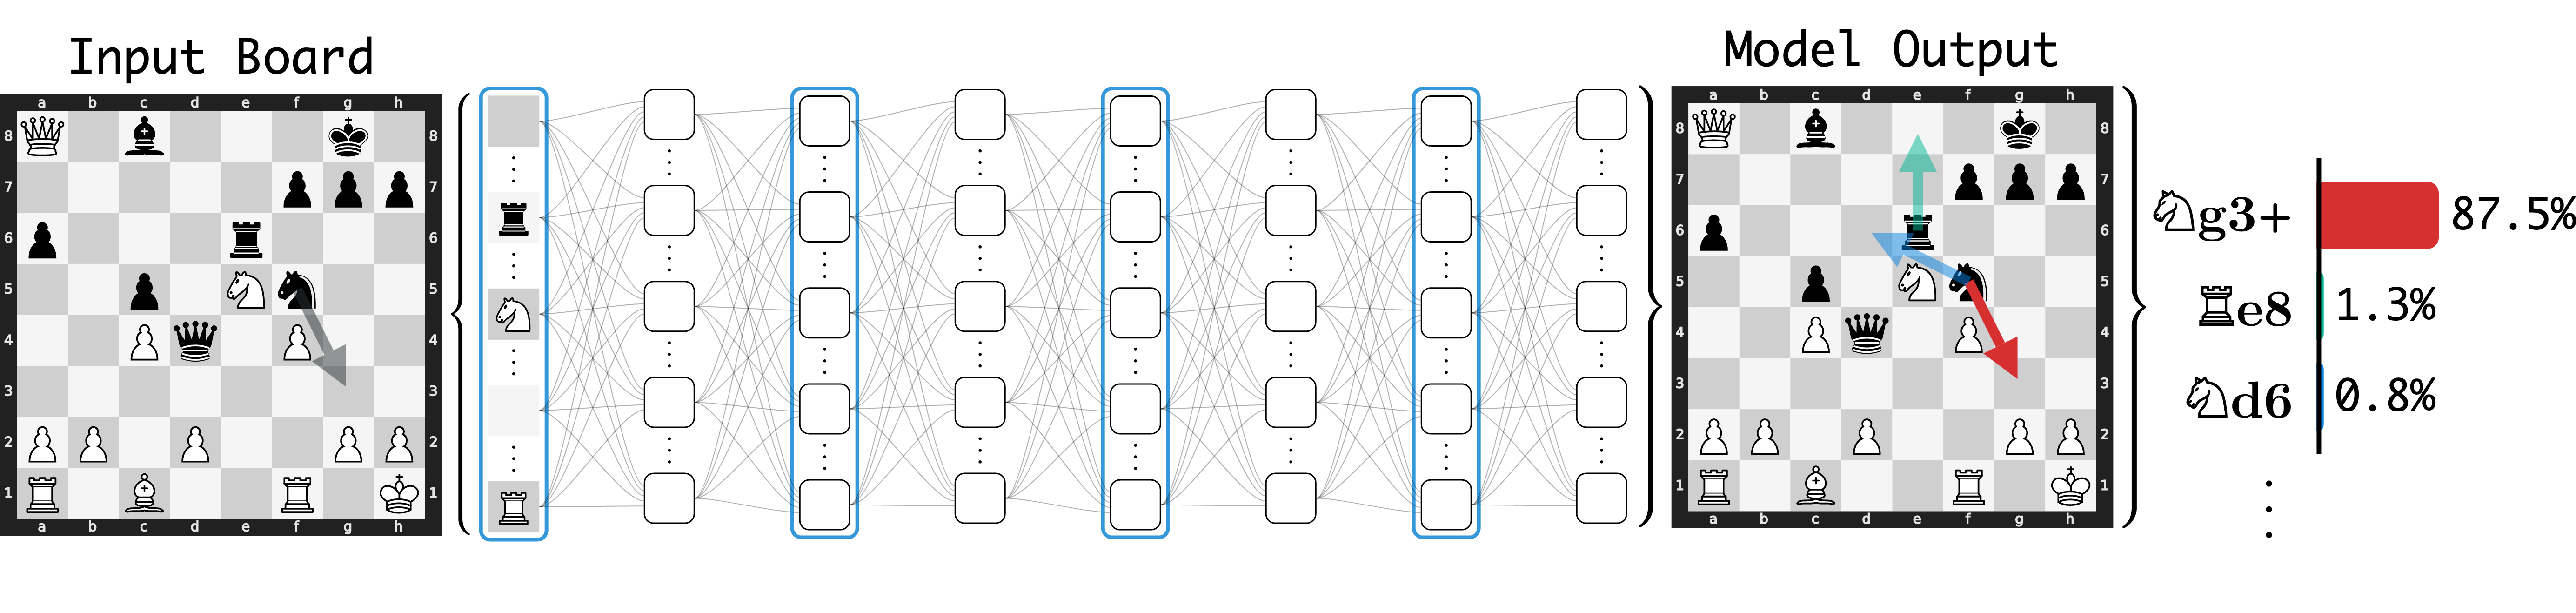

In [14]:
INCLUDE_SQUARES = ["a1", "h3", "e5",  "e6",  "h8"]
forward_pass = LeelaForwardPass(
    board=board,
    policy=dict(top_moves),
    changed_policy=None,
    include_squares=INCLUDE_SQUARES,
    input_arrow_squares=[puzzle.principal_variation[0][2:4]],#INCLUDE_SQUARES,#
    board_heatmap=None,#{puzzle.principal_variation[0][2:4]: fh.COLOR_DICT["first_target"]},
    move_arrow=puzzle.principal_variation[0],
    board_title="Input Board",
)
forward_pass

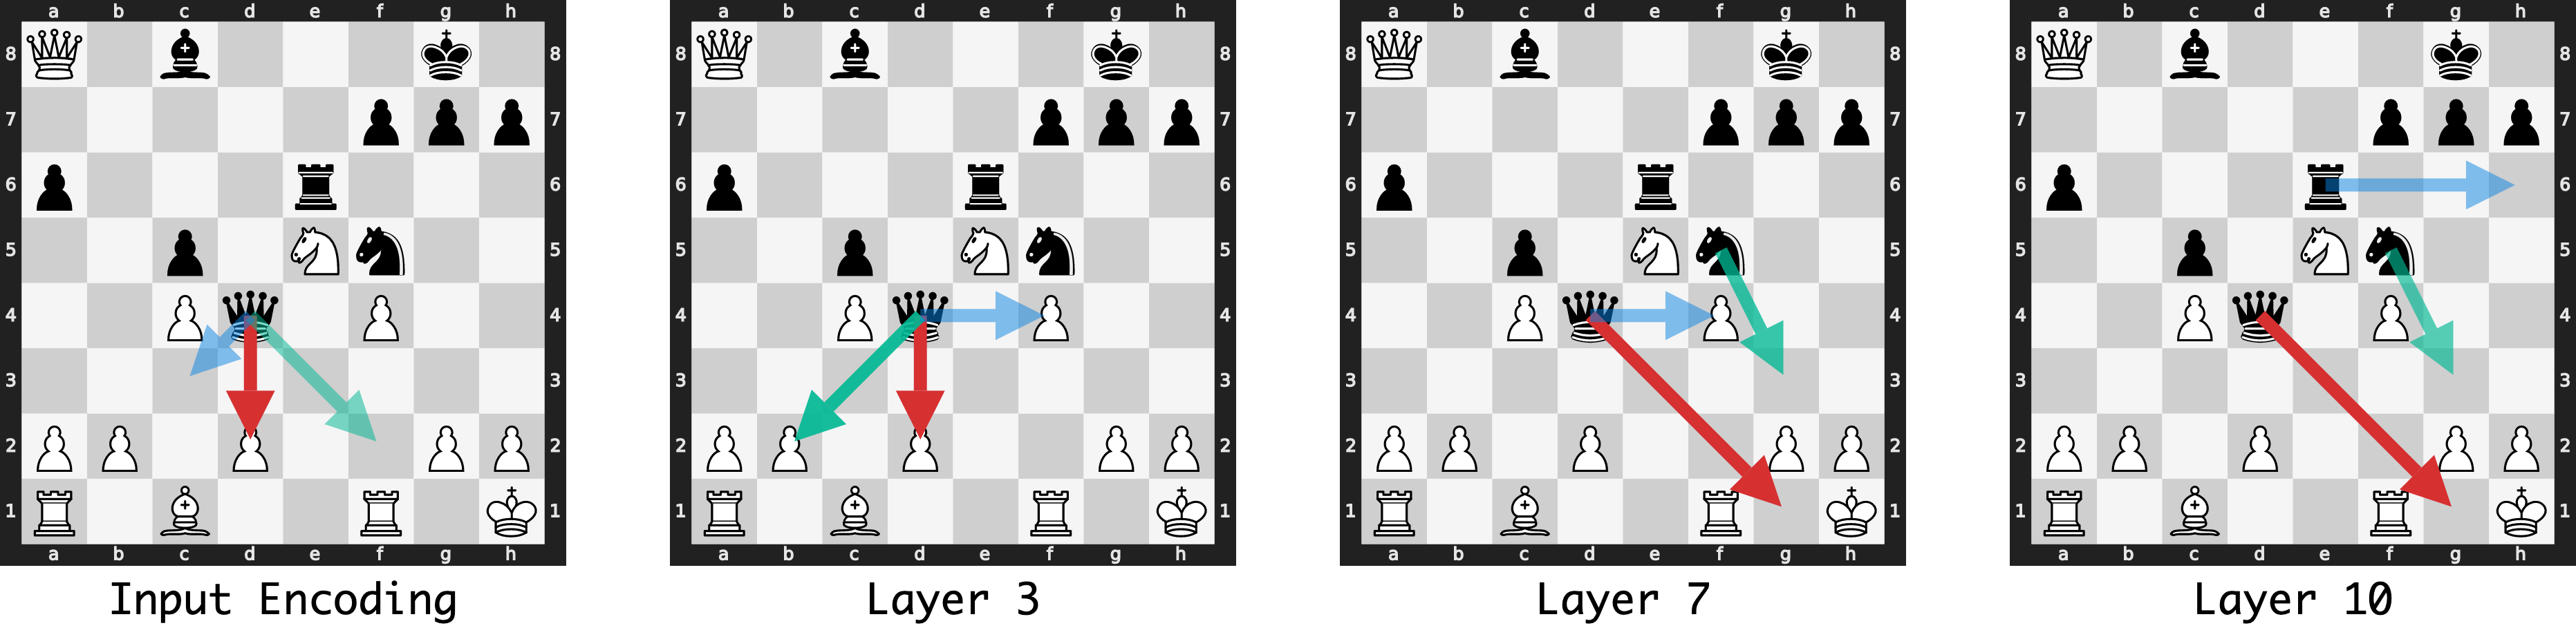

In [15]:
# Create 5 boards for the different layers
layer_indices = [0, 4, 8, 11]  # Input, Layer 3, 7, 11, Full Model
# -1 for the actual layers since its input encoding + 0th layer
layer_names = ["Input Encoding", "Layer 3", "Layer 7", "Layer 10"]
layer_boards = []
board_plots = []  # ADD THIS LINE to store individual board plots

for layer_idx, layer_name in zip(layer_indices, layer_names):
    # Get policy for this layer
    layer_policy = results[0]['layers'][layer_idx]['policy_as_dict']
    
    # Create translucent arrows for top moves
    arrows_for_board = make_translucent_arrows(
        policy_as_dict=layer_policy,
        k=3,  # Show top 5 moves
        colors=move_colors
    )
    
    # Create board plot with arrows
    board_plot = board.plot(
        arrows=arrows_for_board,
        show_lastmove=False
    ).scale(2.1)
    
    board_plots.append(board_plot)  # ADD THIS LINE to store the individual board
    
    # Add layer title BELOW the board
    title = ice.Text(layer_name, ice.FontStyle("Monaco", size=60))
    board_with_title = ice.Arrange([board_plot, title], gap=10, arrange_direction=ice.VERTICAL)
    
    # Crop to remove extra whitespace
    board_with_title = board_with_title.crop(board_with_title.bounds)
    layer_boards.append(board_with_title)

# Arrange the 5 boards horizontally
boards_row = ice.Arrange(layer_boards, gap=150, arrange_direction=ice.HORIZONTAL)

# Display the result
boards_row

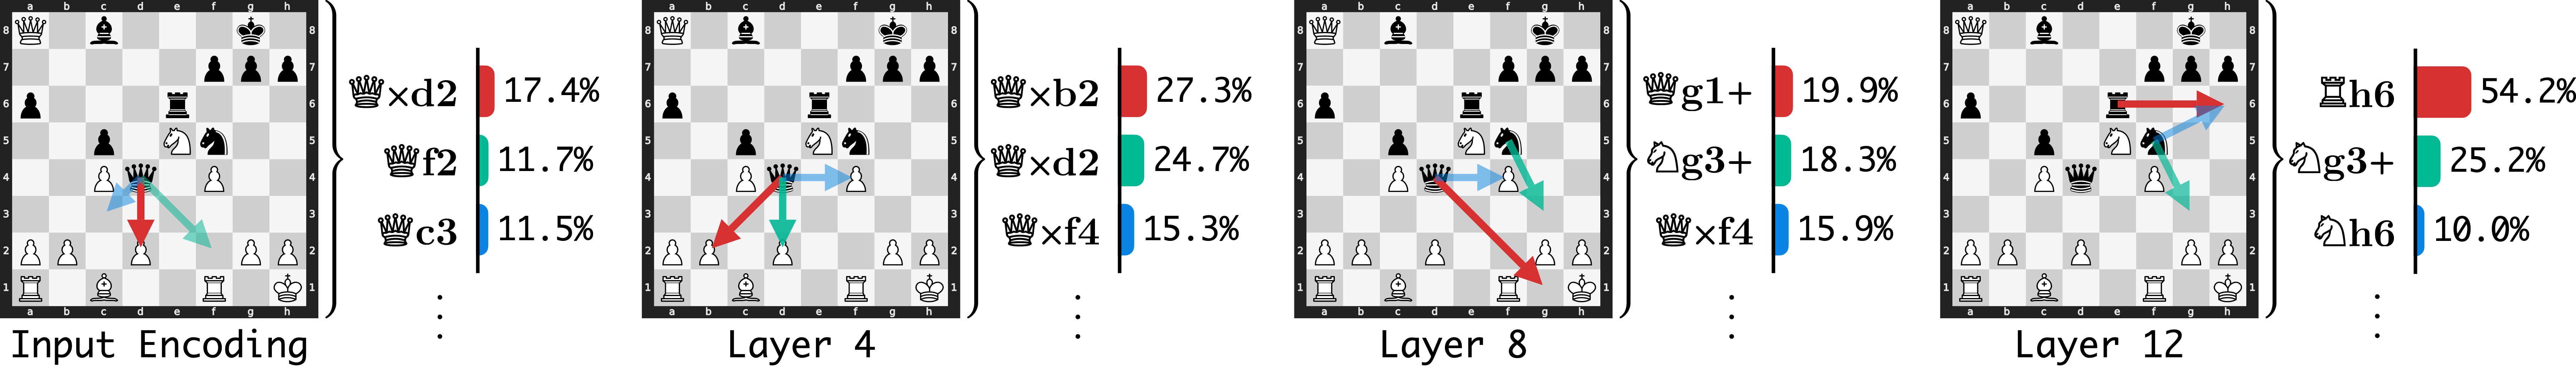

In [16]:
# Create 4 boards for the different layers with policy bars
layer_indices = [0, 5, 9, 13]  # Input, Layer 3, 7, 11, Full Model
# -1 for the actual layers since its input encoding + 0th layer
layer_names = ["Input Encoding", "Layer 4", "Layer 8", "Layer 12"]
layer_boards = []
board_plots = []  # Store individual board plots

for layer_idx, layer_name in zip(layer_indices, layer_names):
    # Get policy for this layer
    layer_policy = results[0]['layers'][layer_idx]['policy_as_dict']
    
    # Create translucent arrows for top moves
    arrows_for_board = make_translucent_arrows(
        policy_as_dict=layer_policy,
        k=3,  # Show top 10 moves
        colors=move_colors
    )
    
    # Create board plot with arrows
    board_plot = board.plot(
        arrows=arrows_for_board,
        show_lastmove=False
    ).scale(2.3)
    
    board_plots.append(board_plot)  # Store the individual board
    
    # Add layer title BELOW the board
    title = ice.Text(layer_name, ice.FontStyle("Monaco", size=100))
    
    # First arrange board and title vertically
    board_with_title = ice.Arrange([board_plot, title], gap=10, arrange_direction=ice.VERTICAL)
    
    # Create policy bar for this layer
    # Get top moves for the policy bar (similar to what's done in LeelaForwardPass)
    top_moves_for_layer = get_top_k_moves(layer_policy, k=3)
    policy_dict_uci = dict(top_moves_for_layer)

    policy_dict_san = {
        board.pc_board.san(chess.Move.from_uci(move)): prob
        for move, prob in policy_dict_uci.items()
    }
    
    policy_bar = PolicyBarWithColors(
        numbers=list(policy_dict_san.values()),
        bar_labels=list(policy_dict_san.keys()),
        bar_colors=move_colors,        
        label_font_family=fh.FONT_FAMILY,
        bar_height=60,  # Slightly smaller than the main figure
        use_tex=True,
        move_scale=0.6,  # Smaller scale for these bars
        bar_width=25,    # Smaller width
        label_font_size=18
    ).scale(5)  # Scale down the entire policy bar
    
    # Create brace sized to board height (without title)
    brace = ice.Brace(target_width=board_plot.bounds.height, target_height=50)
    brace = ice.Transform(child=brace, rotation=-90).pad_left(20).pad_right(20)
    
    # First arrange board+title and policy bar without the brace
    board_with_components = ice.Arrange(
        [board_with_title, policy_bar.pad_top(60)], 
        gap=80,  # Increase gap to make room for brace
        arrange_direction=ice.HORIZONTAL
    )
    
    # Then manually add the brace positioned relative to just the board
    board_with_components += brace.relative_to(
        board_plot, 
        ice.MIDDLE_LEFT, 
        ice.MIDDLE_RIGHT
    ).move(0, 0)  # Position it between board and policy bar

    # Crop to remove extra whitespace
    board_with_components = board_with_components.crop(board_with_components.bounds)
    layer_boards.append(board_with_components)

# Arrange the 4 boards horizontally
boards_row = ice.Arrange(layer_boards, gap=120, arrange_direction=ice.HORIZONTAL)


boards_row

In [17]:
    # First arrange board+title and policy bar without the brace
    board_with_components = ice.Arrange(
        [board_with_title, policy_bar], 
        gap=80,  # Increase gap to make room for brace
        arrange_direction=ice.HORIZONTAL
    )
    

In [18]:
fh.COLORS

['#00b894', '#0984e3', '#d63031', '#495057']

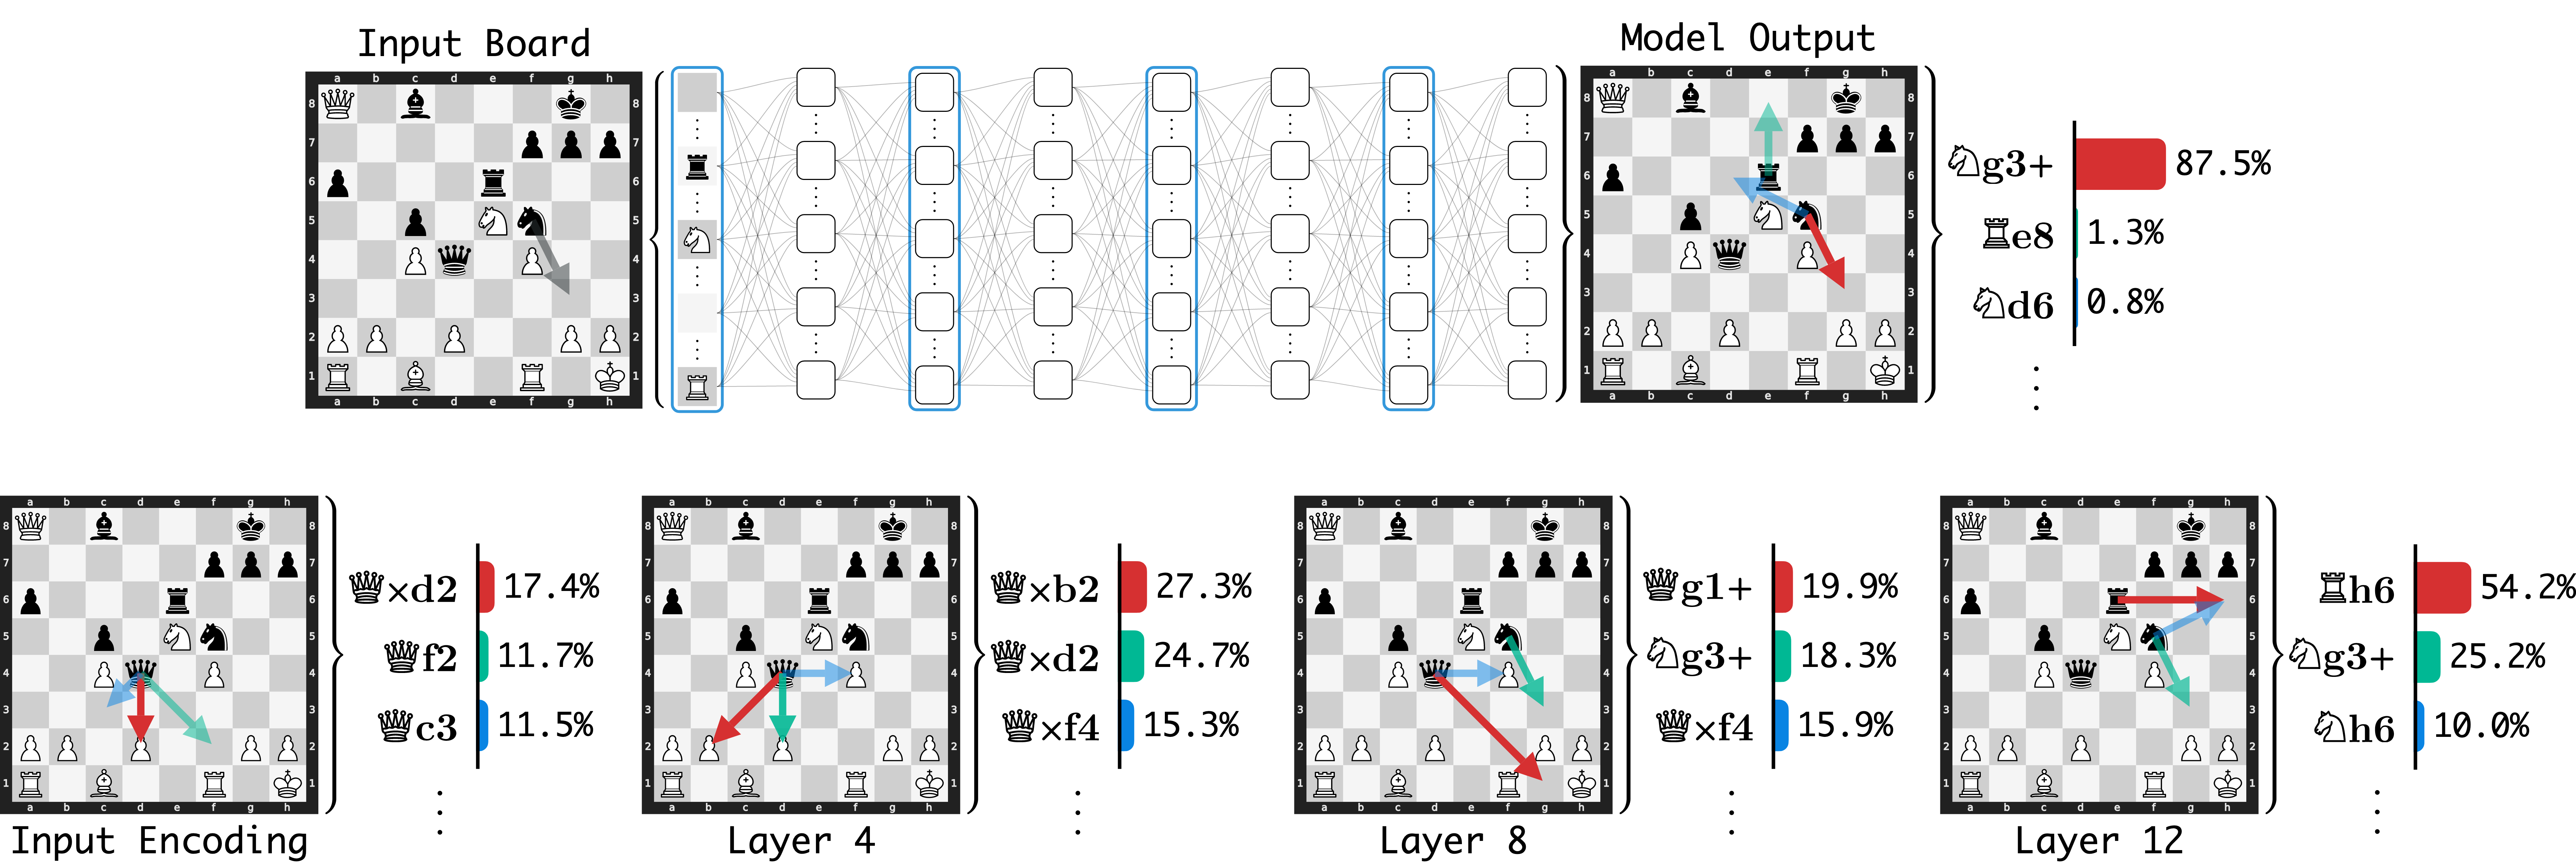

In [19]:
# Combine the forward pass with the boards row
intermediate_scene = ice.Arrange([forward_pass, boards_row], gap=80, arrange_direction=ice.VERTICAL)

# Add padding and background
# scene = complete_scene.pad(50).background(ice.WHITE)

intermediate_scene

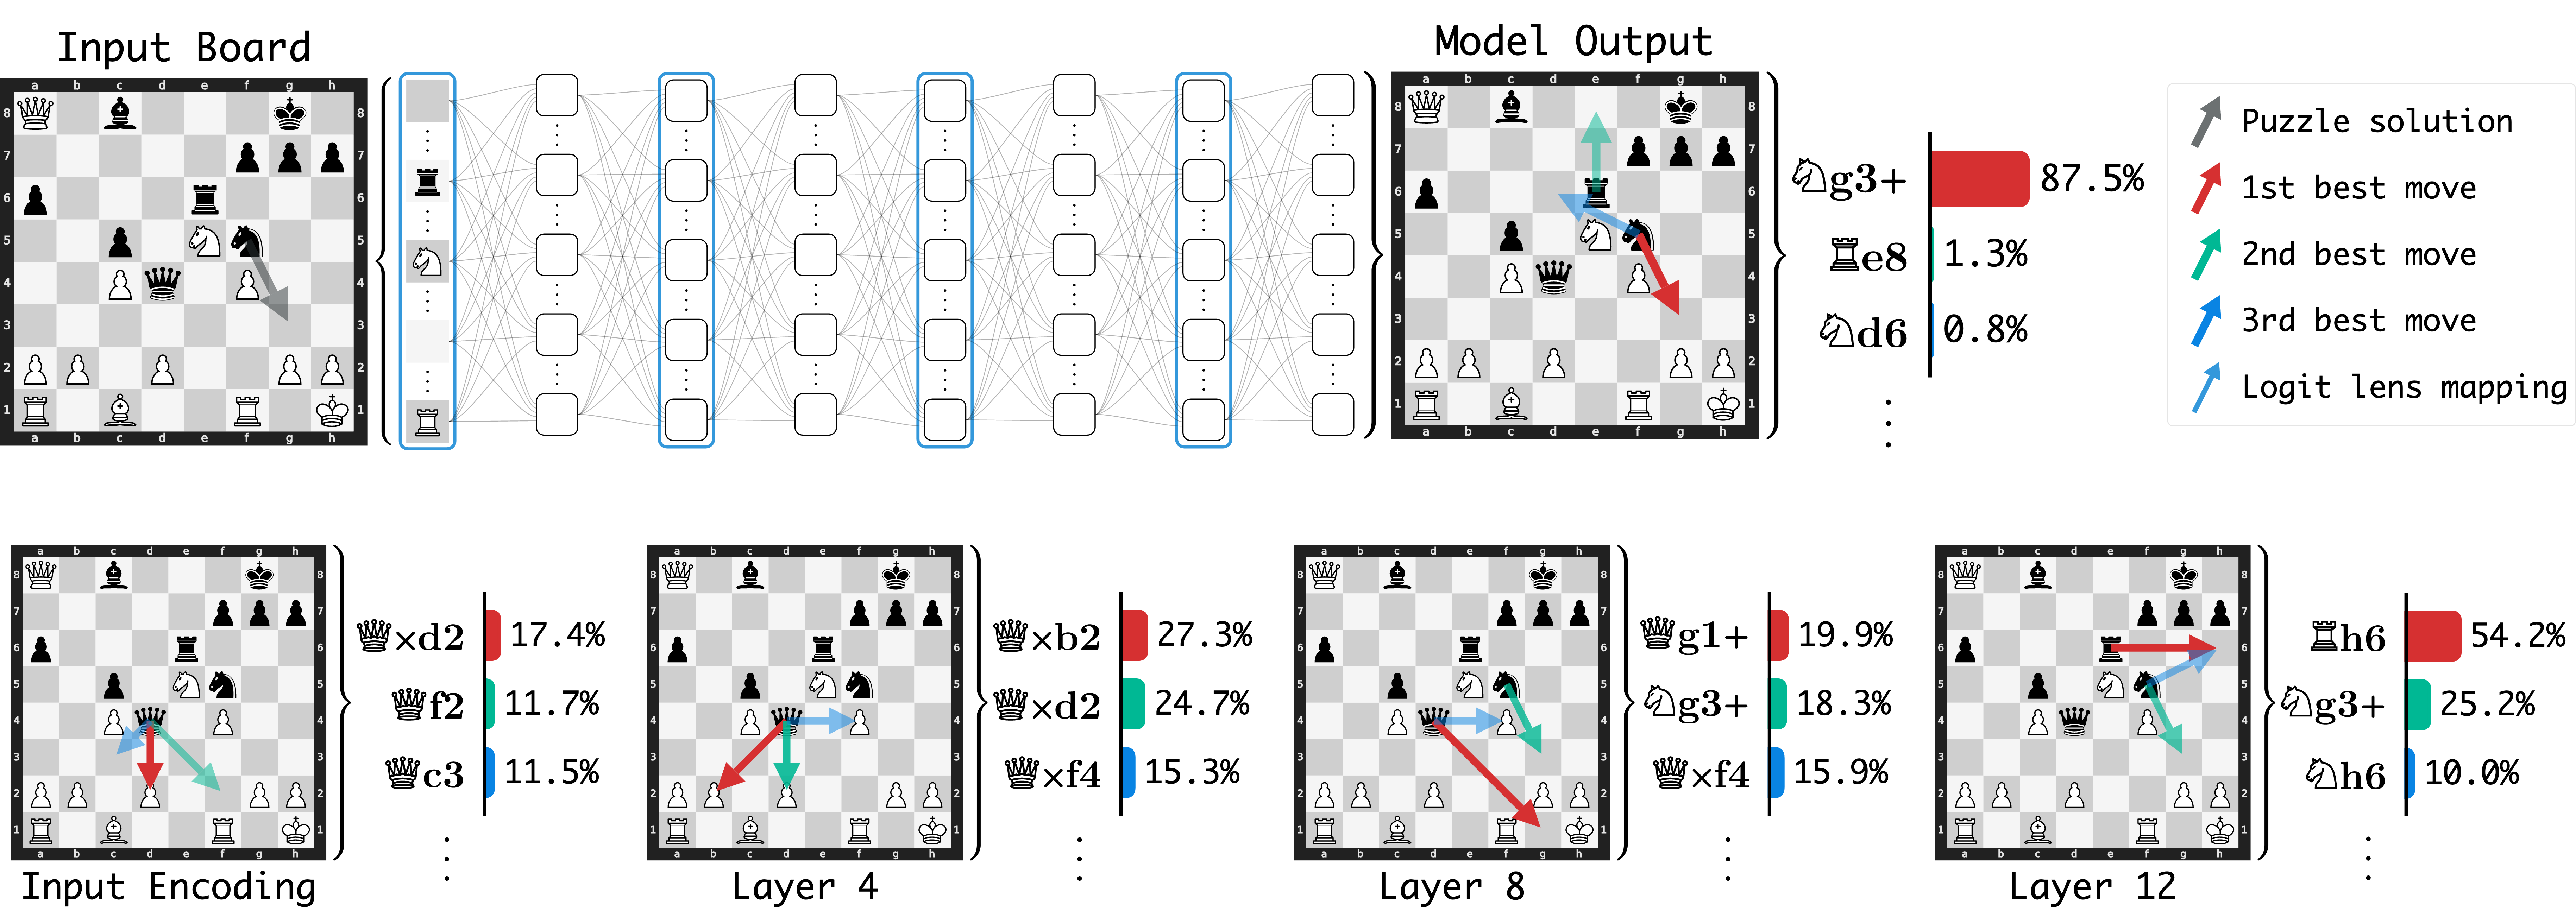

In [20]:
# Create legend with updated entries
empty_square = ice.SVG(raw_svg=chess.svg.piece(chess.Piece.from_symbol("P"))).opacity(0)

# Create best move arrow following the style from the other code
best_move_arrow = ice.Arrow(
    (0.0, 0.0),
    (50.0, -100.0),
    line_path_style=ice.PathStyle(
        color=ice.Color.interpolate(
            ice.Color.from_hex(fh.BEST_MOVE_COLOR), ice.WHITE, 0.3
        ),
        thickness=16,
    ),
    arrow_head_style=ice.ArrowHeadStyle.FILLED_TRIANGLE,
)
best_move_arrow = ice.Rectangle(Neuron(content=empty_square).bounds).add_centered(
    best_move_arrow
)

# Create arrows for top 3 moves with your move_colors
move_labels = ["1st best move", "2nd best move", "3rd best move"]

# Create target square frame
target_square = add_frame(
    empty_square,
    fill_color=ice.Color.from_hex(fh.COLOR_DICT["first_target"]),
)

legend_symbols = {    
    "Puzzle solution": best_move_arrow,
}

# Add the top 3 move entries using move_colors
for i, label in enumerate(move_labels):
    move_arrow = ice.Arrow(
        (0.0, 0.0),
        (50.0, -100.0),
        line_path_style=ice.PathStyle(
            color=move_colors[i],
            thickness=16,
        ),
        arrow_head_style=ice.ArrowHeadStyle.FILLED_TRIANGLE,
    )
    move_arrow = ice.Rectangle(Neuron(content=empty_square).bounds).add_centered(
        move_arrow
    )
    legend_symbols[label] = move_arrow

# Add the remaining entries
legend_symbols.update({
#    "Neural network layer": ice.Rectangle(
#        target_square.bounds,  # Same size as target square
#        border_color=ice.Color.from_hex("#3498db"),
#        border_thickness=3,
#        fill_color=ice.TRANSPARENT,
#        border_radius=20
#    ),
    "Logit lens mapping": ice.Arrow(
        (0.0, 0.0), (50.0, -100.0),
        line_path_style=ice.PathStyle(
            color=ice.Color.from_hex("#3498db"),
            thickness=10
        ),
        arrow_head_style=ice.ArrowHeadStyle.FILLED_TRIANGLE,
    ),
})


# Normalize symbol heights using containers
max_height = max(symbol.bounds.height for symbol in legend_symbols.values())
max_width = max(symbol.bounds.width for symbol in legend_symbols.values())

normalized_symbols = {}
for text, symbol in legend_symbols.items():
    # Create a container of uniform size
    container = ice.Rectangle(
        ice.Bounds.from_size(max_width, max_height),
        fill_color=ice.TRANSPARENT
    )
    # Center the symbol in the container
    normalized_symbol = container.add_centered(symbol)
    normalized_symbols[text] = normalized_symbol

legend_symbols = normalized_symbols

# Scale and arrange legend (rest of your code continues)
legend_symbols = {k: v.scale(1.0).pad(5) for k, v in legend_symbols.items()}
legend_texts = {
    text: ice.Text(
        text,
        font_style=ice.FontStyle(fh.FONT_FAMILY, size=60),
        align=ice.Text.Align.LEFT,
    )    
    for text in legend_symbols
}

legend_items = [
    ice.Arrange([symbol, legend_texts[text]], gap=10, arrange_direction=ice.HORIZONTAL)
    for text, symbol in legend_symbols.items()
]

legend_contents = legend_items[0]
for item in legend_items[1:]:
    legend_contents += item.pad_top(10).relative_to(legend_contents, ice.TOP_LEFT, ice.BOTTOM_LEFT)

legend_background = ice.Rectangle(
    legend_contents.pad(15).bounds,
    border_color=ice.BLACK.with_alpha(0.1),
    fill_color=ice.WHITE.with_alpha(0.9),
    border_thickness=2,
    border_radius=10,
)

legend = legend_background.add_centered(legend_contents).scale(1.3)

top_section = ice.Arrange([forward_pass, legend], gap=60, arrange_direction=ice.HORIZONTAL).scale(1.1)

# Arrange forward pass and legend horizontally
# bot_section = ice.Arrange([boards_row, legend], gap=100, arrange_direction=ice.HORIZONTAL)

# Combine with boards below
final_scene = ice.Arrange([top_section, boards_row], gap=100, arrange_direction=ice.VERTICAL)

# Display the result
final_scene

In [21]:
arrow_offsets = [0, 300, 450, 600]

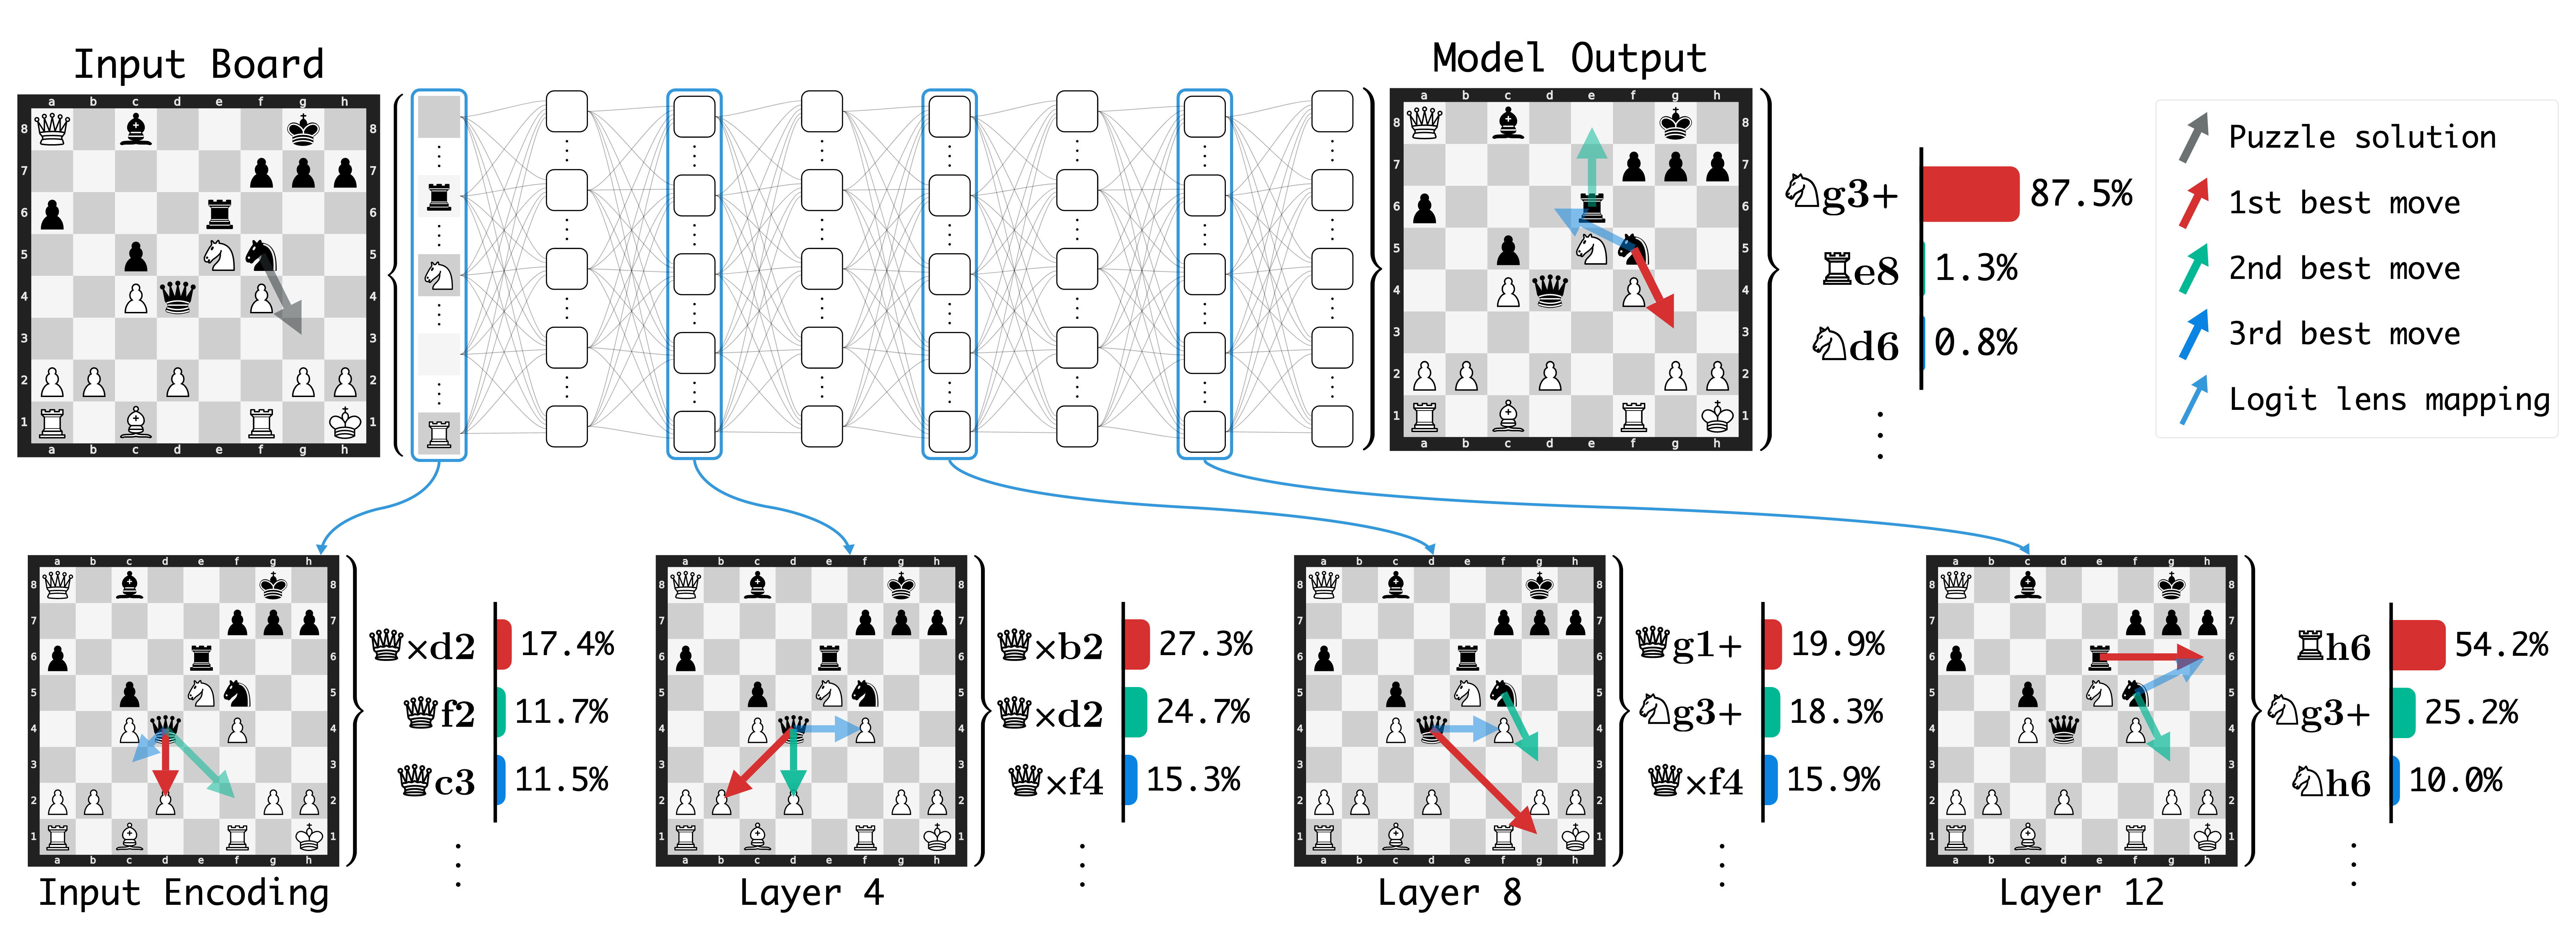

In [22]:
with final_scene:
    for board_idx, layer_idx in enumerate(layer_indices):
        if layer_idx == 0:
            # Use the input rectangle for the first board
            layer_rect = forward_pass.layer_rectangles[0]  # Input rectangle
        else:
            # Map to correct rectangle index: 0=input, 2=layer3, 4=layer7, 6=layer11, 8=layer15
            rect_idx = 2 + (board_idx - 1) * 2  # Maps 1→2, 2→4, 3→6, 4→8
            layer_rect = forward_pass.layer_rectangles[rect_idx]
        
        # Skip if no rectangle for this layer
        if layer_rect is None:
            continue
            
        start_x, start_y = layer_rect.relative_bounds.bottom_middle
        
        # Get exact top center of each board arrangement
        board_with_title = layer_boards[board_idx]
        board_top_x, board_top_y = board_with_title.relative_bounds.top_middle
        
        # Calculate intermediate points
        mid_x = (start_x + board_top_x-arrow_offsets[board_idx]) / 2
        mid_y = (start_y + board_top_y) / 2
        
        # 5 points for straight entry/exit with curved middle
        arrow = ice.CurvedCubicLine(
            points=[
                (start_x, start_y),              # Point 0: Start (rectangle bottom)
                (start_x, start_y + 100),        # Point 1: Control for straight down
                (mid_x, mid_y),                  # Point 2: Middle connection point
                (board_top_x-arrow_offsets[board_idx], board_top_y - 100), # Point 3: Control for straight up  
                (board_top_x-arrow_offsets[board_idx], board_top_y)       # Point 4: End (board top)
            ],
            path_style=ice.PathStyle(
                color=ice.Color.from_hex("#3498db"),#.with_alpha(0.8), 
                thickness=8
            )
        )
        arrow_with_head = ice.ArrowPath(arrow, arrow_head_style=ice.ArrowHeadStyle.FILLED_TRIANGLE)
        final_scene += arrow_with_head

# Add padding and background
final_scene = final_scene.pad(50).background(ice.WHITE)
final_scene

In [23]:
final_scene.render("Figures/main_figure.pdf")

In [24]:
final_scene.render("Figures/main_figure.png")

## Probability Table

In [25]:
import chess
import numpy as np

def create_split_probability_tables(results_dict):
    """
    Creates two split LaTeX probability tables with improved move ordering and labeling.
    - Moves are ordered by their peak probability across ALL layers.
    - Layer headers are formatted as "Layer X".
    - The table is split into two non-overlapping parts.
    """
    # --- 1. Extract and Validate Data ---
    if not results_dict or not isinstance(results_dict, list):
        return "% No valid data provided."

    board_result = results_dict[0]
    layers_data = board_result.get('layers', {})
    board = board_result.get('board')

    if not layers_data or not board:
        return "% Missing 'layers' or 'board' data in the dictionary."

    layer_indices = sorted(layers_data.keys())
    if not layer_indices:
        return "% No layer data found."
    
    # --- 2. Define Split Point ---
    split_index = len(layer_indices) // 2
    table1_indices = layer_indices[:split_index]
    table2_indices = layer_indices[split_index:] # Non-overlapping split

    # --- 3. Order Moves by Peak Probability Across ALL Layers ---
    try:
        all_legal_moves_uci = [move.uci() for move in board.pc_board.legal_moves]
    except AttributeError:
        return "% Board object is invalid."

    def get_max_prob_overall(move_uci):
        """Helper function to find the max probability of a move in any layer."""
        max_prob = 0
        # Iterate through ALL layer indices
        for layer_idx in layer_indices:
            prob = layers_data[layer_idx].get('policy_as_dict', {}).get(move_uci, 0.0)
            if prob > max_prob:
                max_prob = prob
        return max_prob

    # Sort moves based on the highest probability they reached in ANY layer
    sorted_moves_uci = sorted(
        all_legal_moves_uci,
        key=get_max_prob_overall,
        reverse=True
    )

    # --- 4. Helper Function to Generate Each Sub-Table ---
    def _generate_sub_table(table_layer_indices, caption_part):
        num_cols = len(table_layer_indices) + 1
        col_spec = 'l' + 'r' * (num_cols - 1)

        latex_string = f"""\\begin{{table*}}[h!]
\\centering
\\caption{{Layer-wise policy probability evolution ({caption_part})}}
\\resizebox{{\\textwidth}}{{!}}{{%
\\begin{{tabular}}{{{col_spec}}}
\\toprule
\\textbf{{Move}}"""

        # Add Header Row with new labeling
        final_layer_idx = max(layer_indices)
        for layer_idx in table_layer_indices:
            if layer_idx == 0:
                header = "Input"
            elif layer_idx == final_layer_idx:
                header = "Final"
            else:
                header = f"Layer {layer_idx - 1}" # Use "Layer X" format
            latex_string += f" & \\textbf{{{header}}}"
        latex_string += " \\\\\n\\midrule\n"

        # Add Data Rows
        for move_uci in sorted_moves_uci:
            move_san = board.pc_board.san(chess.Move.from_uci(move_uci))
            move_cell = f"\\wmove{{{move_san}}}"
            latex_string += move_cell
            
            for layer_idx in table_layer_indices:
                policy_dict = layers_data[layer_idx].get('policy_as_dict', {})
                prob = policy_dict.get(move_uci, 0.0) * 100
                
                # Round the probability to an integer ONLY for the color calculation
                prob_for_color = round(prob)
                
                # Create the LaTeX cell with both a color command and the 2-decimal text
                if prob_for_color > 0:
                    latex_string += f" & \\cellcolor{{heatmapcolor!{prob_for_color}!white}}{prob:.2f}\\%"
                else:
                    # Don't color cells with zero probability
                    latex_string += f" & {prob:.2f}\\%"
            latex_string += " \\\\\n"

        latex_string += """\\bottomrule
\\end{tabular}%
}
\\end{table*}"""
        return latex_string

    # --- 5. Generate and Return Both Tables ---
    caption1 = f"Part 1: Input to Layer {split_index - 2}"
    caption2 = f"Part 2: Layer {split_index - 1} to Final"
    
    latex_part1 = _generate_sub_table(table1_indices, caption1)
    latex_part2 = _generate_sub_table(table2_indices, caption2)

    return latex_part1 + "\n\n" + latex_part2

In [26]:
latex_table = create_split_probability_tables(results)

In [27]:
print(latex_table)

\begin{table*}[h!]
\centering
\caption{Layer-wise policy probability evolution (Part 1: Input to Layer 6)}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lrrrrrrrr}
\toprule
\textbf{Move} & \textbf{Input} & \textbf{Layer 0} & \textbf{Layer 1} & \textbf{Layer 2} & \textbf{Layer 3} & \textbf{Layer 4} & \textbf{Layer 5} & \textbf{Layer 6} \\
\midrule
\wmove{Ng3+} & \cellcolor{heatmapcolor!4!white}3.70\% & 0.04\% & 0.20\% & \cellcolor{heatmapcolor!2!white}2.30\% & \cellcolor{heatmapcolor!9!white}8.94\% & \cellcolor{heatmapcolor!1!white}0.62\% & \cellcolor{heatmapcolor!21!white}21.09\% & \cellcolor{heatmapcolor!25!white}24.77\% \\
\wmove{Rh6} & 0.01\% & 0.01\% & 0.03\% & 0.10\% & 0.11\% & 0.04\% & 0.03\% & \cellcolor{heatmapcolor!3!white}3.50\% \\
\wmove{Qg1+} & \cellcolor{heatmapcolor!7!white}6.51\% & \cellcolor{heatmapcolor!2!white}1.65\% & \cellcolor{heatmapcolor!5!white}5.34\% & \cellcolor{heatmapcolor!9!white}8.90\% & \cellcolor{heatmapcolor!9!white}8.76\% & \cellcolor{heatmapcolor!1!whit